# K-Nearest Neighbors (KNN)

Este notebook implementa un modelo KNN para clasificación usando el dataset de amenazas de ciberseguridad.

## Características:
- Preprocesamiento de datos con escalado estándar
- División train/test estratificada
- Evaluación completa con métricas de clasificación
- Visualización de matriz de confusión y curva ROC
- Algoritmo basado en instancias (lazy learning)


In [1]:
# Imports y configuración
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Configuración del dataset
DATA_PATH = Path(r"C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\modelos\Data\Global_Cybersecurity_Threats_2015-2024.csv")
TARGET_COLUMN = 'Attack Type'


In [3]:
# Carga y preparación de datos
df = pd.read_csv(DATA_PATH)

# Separar variables y objetivo
y = df[TARGET_COLUMN]
X = df.drop(columns=[TARGET_COLUMN])

# Mapear etiquetas no numéricas a códigos
if not pd.api.types.is_numeric_dtype(y):
    y = y.astype('category').cat.codes
    print(f"Mapeo de etiquetas a códigos aplicado sobre '{TARGET_COLUMN}'.")

# One-hot encoding para columnas categóricas en X
X = pd.get_dummies(X, drop_first=True)

print("Shape X:", X.shape, "- y:", y.shape)
print("Clases en y y conteo:")
print(y.value_counts())
X.head()


Mapeo de etiquetas a códigos aplicado sobre 'Attack Type'.
Shape X: (3000, 29) - y: (3000,)
Clases en y y conteo:
0    531
3    529
5    503
4    493
1    485
2    459
Name: count, dtype: int64


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours),Country_Brazil,Country_China,Country_France,Country_Germany,Country_India,Country_Japan,...,Attack Source_Insider,Attack Source_Nation-state,Attack Source_Unknown,Security Vulnerability Type_Unpatched Software,Security Vulnerability Type_Weak Passwords,Security Vulnerability Type_Zero-day,Defense Mechanism Used_Antivirus,Defense Mechanism Used_Encryption,Defense Mechanism Used_Firewall,Defense Mechanism Used_VPN
0,2019,80.53,773169,63,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,2019,62.19,295961,71,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,2017,38.65,605895,20,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
3,2024,41.44,659320,7,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,2018,74.41,810682,68,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [4]:
# Train/Test split y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos de entrenamiento escalados:")
print(X_train_scaled[:3])


Datos de entrenamiento escalados:
[[-1.57195577  0.8907771  -0.10956267 -1.51095874 -0.35006347 -0.31687956
  -0.33256119 -0.33641127  2.88137564 -0.33564336 -0.32084447 -0.35156152
  -0.31528477 -0.39857302 -0.38939887  2.43647618 -0.43508198 -0.40556536
  -0.39997583 -0.57799177 -0.59339083  1.67436153 -0.5728597  -0.56772709
   1.68888349 -0.51946248 -0.49609064 -0.48694291  1.98707162]
 [ 0.4998146  -0.63340795  0.02634159 -1.46281796 -0.35006347 -0.31687956
  -0.33256119  2.97255203 -0.34705645 -0.33564336 -0.32084447 -0.35156152
  -0.31528477 -0.39857302 -0.38939887  2.43647618 -0.43508198 -0.40556536
  -0.39997583 -0.57799177 -0.59339083  1.67436153 -0.5728597   1.76140969
  -0.59210716  1.92506684 -0.49609064 -0.48694291 -0.50325312]
 [ 1.19040473 -0.65384124  0.92667753 -1.51095874 -0.35006347 -0.31687956
  -0.33256119 -0.33641127 -0.34705645 -0.33564336 -0.32084447 -0.35156152
  -0.31528477 -0.39857302 -0.38939887 -0.4104288   2.29841739 -0.40556536
  -0.39997583 -0.57799177 

In [5]:
# Función de evaluación
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    # Detectar número de clases
    clases_unicas = np.unique(y_test)
    num_clases = len(clases_unicas)
    promedio = 'binary' if num_clases == 2 else 'weighted'

    proba = None
    try:
        proba_pred = modelo.predict_proba(X_test)
        # Si es binario, usar la columna positiva; si es multiclase, usar toda la matriz
        proba = proba_pred[:, 1] if proba_pred.ndim == 2 and proba_pred.shape[1] == 2 else proba_pred
    except Exception:
        try:
            # Algunos modelos solo exponen decision_function
            from sklearn.utils.validation import check_is_fitted
            check_is_fitted(modelo)
            z = modelo.decision_function(X_test)
            if z.ndim == 1:
                # Normalización min-max a [0,1]
                z = (z - z.min()) / (z.max() - z.min() + 1e-9)
                proba = np.clip(z, 0, 1)
            else:
                # Multiclase: aproximación softmax
                exp_z = np.exp(z - z.max(axis=1, keepdims=True))
                proba = exp_z / (exp_z.sum(axis=1, keepdims=True) + 1e-9)
        except Exception:
            pass

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=promedio, zero_division=0),
        'recall': recall_score(y_test, y_pred, average=promedio, zero_division=0),
        'f1': f1_score(y_test, y_pred, average=promedio, zero_division=0),
    }

    # ROC AUC
    metrics['roc_auc'] = np.nan
    if proba is not None:
        try:
            if num_clases == 2 and (np.ndim(proba) == 1 or (np.ndim(proba) == 2 and proba.shape[1] == 2)):
                # Si proba es matriz 2-col, usar columna positiva
                p = proba if np.ndim(proba) == 1 else proba[:, 1]
                metrics['roc_auc'] = roc_auc_score(y_test, p)
            elif num_clases > 2 and np.ndim(proba) == 2 and proba.shape[1] == num_clases:
                metrics['roc_auc'] = roc_auc_score(y_test, proba, multi_class='ovr', average='weighted')
        except Exception:
            metrics['roc_auc'] = np.nan

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.show()

    # Curva ROC solo para binario con proba 1D
    if proba is not None and num_clases == 2:
        p = proba if np.ndim(proba) == 1 else proba[:, 1]
        RocCurveDisplay.from_predictions(y_test, p)
        plt.title(f"Curva ROC - {nombre}")
        plt.show()

    return metrics


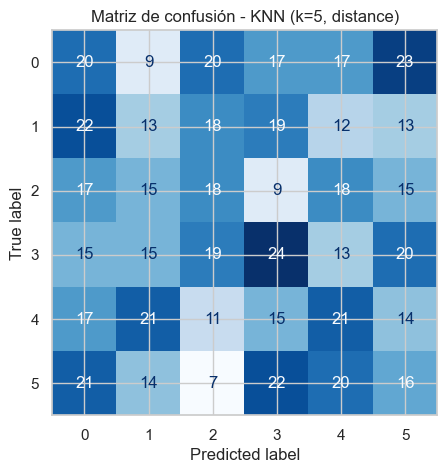

Métricas KNN:
  accuracy: 0.1867
  precision: 0.1861
  recall: 0.1867
  f1: 0.1863
  roc_auc: 0.5161


In [6]:
# Entrenamiento del modelo KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_scaled, y_train)

# Evaluación del modelo
metrics_knn = evaluar_modelo("KNN (k=5, distance)", knn, X_test_scaled, y_test)

print("Métricas KNN:")
for k, v in metrics_knn.items():
    print(f"  {k}: {v:.4f}")
